# Online learning for an MLP using extended Kalman filtering

We perform sequential (recursive) Bayesian inference for the parameters of a multi layer perceptron (MLP)
using the extended Kalman filter. 
To do this, we treat the parameters of the model as the unknown hidden states.
We assume that these are approximately constant over time (we add a small amount of Gaussian drift,
for numerical stability.)
The graphical model is shown below.

![RLS](https://github.com/probml/dynamax/blob/main/docs/figures/rlsDgm.png?raw=true)

The model has the following form

\begin{align*}
\theta_t &=  \theta_{t-1} + q_t, \; q_t \sim N(0, 0.01 I)  \\
y_t &= h(\theta_t, x_t) + r_t, \; r_t \sim N(0, \sigma^2)
\end{align*}

This is a NLG-SSM, where $h$ is the nonlinear observation model.
For details, see sec 17.5.2 of [Probabilistic Machine Learning: Advanced Topics](https://probml.github.io/pml-book/book2.html).

For a video of the training in action see,
https://github.com/probml/probml-data/blob/main/data/ekf_mlp_demo.mp4



## Setup

In [1]:
from jax import numpy as jnp
from matplotlib import pyplot as plt
import numpy as np

from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import jax.random as jr
import jax.numpy as jnp
import flax.linen as nn
from jax.flatten_util import ravel_pytree
from jax import vmap



In [2]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax


from dynamax.nonlinear_gaussian_ssm.nonlinear_gaussian_ssm import ParamsNLGSSM
from dynamax.nonlinear_gaussian_ssm.extended_kalman_filter import extended_kalman_filter

## Data



In [3]:


def sample_observations(f, x_min, x_max, x_var=0.1, y_var=3.0, num_obs=200, key=0):
    """Generate random training set for MLP given true function and
    distribution parameters.
    Args:
        f (Callable): True function.
        x_min (float): Min x-coordinate to sample from.
        x_max (float): Max x-coordinate to sample from.
        x_var (float, optional): Sampling variance in x-coordinate. Defaults to 0.1.
        y_var (float, optional): Sampling variance in y-coordinate. Defaults to 3.0.
        num_obs (int, optional): Number of training data to generate. Defaults to 200.
        key (int, optional): Random key. Defaults to 0.
    Returns:
        x (num_obs,): x-coordinates of generated data
        y (num_obs,): y-coordinates of generated data
    """
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    keys = jr.split(key, 3)

    # Generate noisy x coordinates
    x_noise = jr.normal(keys[0], (num_obs,)) * x_var
    x = jnp.linspace(x_min, x_max, num_obs) + x_noise

    # Generate noisy y coordinates
    y_noise = jr.normal(keys[1], (num_obs,)) * y_var
    y = f(x) + y_noise

    # Random shuffle (x, y) coordinates
    shuffled_idx = jr.permutation(keys[2], jnp.arange(num_obs))
    x, y = x[shuffled_idx], y[shuffled_idx]
    return x, y

In [4]:
# Generate training set.
# Note that we view the x-coordinates of training data as control inputs
# and the y-coordinates of training data as emissions.
f = lambda x: x - 10 * jnp.cos(x) * jnp.sin(x) + x**3
y_var = 3.0
inputs, emissions = sample_observations(f, x_min=-3, x_max=3, y_var=y_var)

## Neural network

In [5]:

class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.sigmoid(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x


In [6]:


def get_mlp_flattened_params(model_dims, key=0):
    """Generate MLP model, initialize it using dummy input, and
    return the model, its flattened initial parameters, function
    to unflatten parameters, and apply function for the model.
    Args:
        model_dims (List): List of [input_dim, hidden_dim, ..., output_dim]
        key (PRNGKey): Random key. Defaults to 0.
    Returns:
        model: MLP model with given feature dimensions.
        flat_params: Flattened parameters initialized using dummy input.
        unflatten_fn: Function to unflatten parameters.
        apply_fn: fn(flat_params, x) that returns the result of applying the model.
    """
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

In [7]:
input_dim, hidden_dim, output_dim = 1, 6, 1
model_dims = [input_dim, hidden_dim, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)

## Online inference

In [8]:

# Note that the dynamics function is the identity function
# and the emission function is the model apply function
state_dim, emission_dim = flat_params.size, output_dim
ekf_params = ParamsNLGSSM(
    initial_mean=flat_params,
    initial_covariance=jnp.eye(state_dim) * 100,
    dynamics_function=lambda x, u: x,
    dynamics_covariance=jnp.eye(state_dim) * 1e-4,
    emission_function=apply_fn,
    emission_covariance=jnp.eye(emission_dim) * y_var**2,
)

# Run EKF on training set to train MLP
ekf_post = extended_kalman_filter(ekf_params, emissions, inputs=inputs)
w_means, w_covs = ekf_post.filtered_means, ekf_post.filtered_covariances

## Plot results

In [9]:

def plot_mlp_prediction(f, obs, x_grid, w_mean, w_cov, ax, num_samples=100, x_lim=(-3, 3), y_lim=(-30, 30), key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Plot observations (training set)
    ax.plot(obs[0], obs[1], "ok", fillstyle="none", ms=4, alpha=0.5, label="Data")

    # Indicate uncertainty through sampling
    w_samples = jr.multivariate_normal(key, w_mean, w_cov, (num_samples,))
    y_samples = vmap(vmap(f, in_axes=(None, 0)), in_axes=(0, None))(w_samples, x_grid)
    for y_sample in y_samples:
        ax.plot(x_grid, y_sample, color="gray", alpha=0.07)

    # Plot prediction on grid using filtered mean of MLP params
    # y_mean = vmap(f, in_axes=(None, 0))(w_mean, x_grid)
    y_mean = y_samples.mean(axis=0)
    ax.plot(x_grid, y_mean, linewidth=1.5, label="Prediction")

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    #ax.legend(loc=4, borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")

ntraining = 10
ntraining = 20
ntraining = 30
ntraining = 200


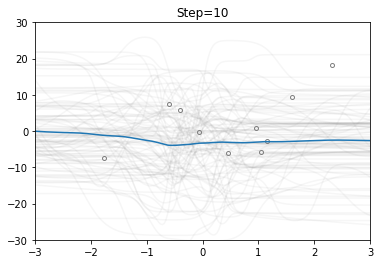

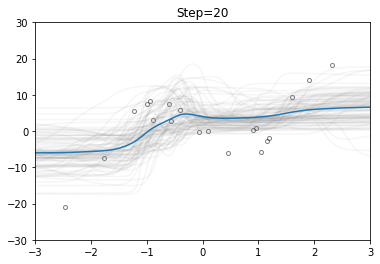

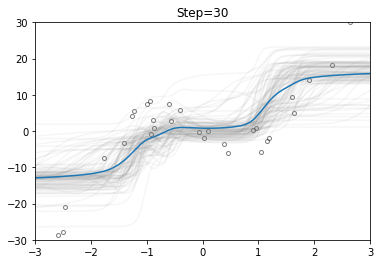

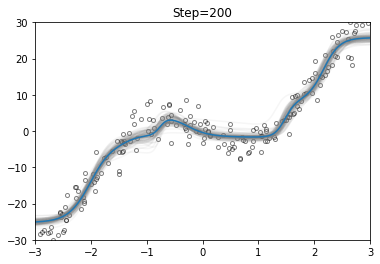

In [10]:
all_figures = {}
inputs_grid = jnp.linspace(inputs.min(), inputs.max(), len(inputs))
intermediate_steps = [10, 20, 30, 200]
for step in intermediate_steps:
    print('ntraining =', step)
    fig, ax = plt.subplots()
    plot_mlp_prediction(
        apply_fn, (inputs[:step], emissions[:step]), inputs_grid, w_means[step - 1], w_covs[step - 1], ax, key=step
    )
    ax.set_title(f"Step={step}")
    all_figures[f"ekf_mlp_step_{step}"] = fig